<a href="https://colab.research.google.com/github/hidt4/python-compchem-book/blob/main/compchem_book_ch12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 12章 励起状態の性質を計算をしてみよう

### 環境構築

#### Google Colab上にPsi4をインストール
2023年8月時点では問題なく動作していましが

今後のColabの開発動向次第では動作しなくなる可能性があります

In [ ]:
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!conda install -q -y -c psi4 psi4 python=3.10
import sys
sys.path.append('/usr/local/lib/python3.10/site-packages')

--2023-07-18 03:13:41--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.201.79, 104.18.200.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.201.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh [following]
--2023-07-18 03:13:41--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 103219356 (98M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>]  98.44M   319MB/s    in 0.3s    

2023-07-18 03:13:42 (319 MB/s) - ‘Miniconda3-latest-Linu

In [ ]:
import os
import datetime
import numpy as np
import pandas as pd
import psi4

print(f'current time: {datetime.datetime.now()}')
print(f'python version:\n{sys.version}')
print(f'numpy version: {np.__version__}')
print(f'pandas version: {pd.__version__}')
print(f'psi4 version: {psi4.__version__}')

current time: 2023-07-18 03:16:33.581015
python version:
3.10.12 (main, Jun  7 2023, 12:45:35) [GCC 9.4.0]
numpy version: 1.22.4
pandas version: 1.5.3
psi4 version: 1.7


#### 必要なライブラリと関数の定義

In [ ]:
# 振動数可視化のためのライブラリ
!pip install py3Dmol
import py3Dmol

!git clone https://github.com/duerrsimon/normal-mode-jupyter.git
sys.path.append('/content/normal-mode-jupyter')
from helpers import show_normal_modes

Cloning into 'normal-mode-jupyter'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 23 (delta 8), reused 17 (delta 4), pack-reused 0
Unpacking objects: 100% (23/23), 801.95 KiB | 3.08 MiB/s, done.


In [ ]:
def show_3D(mol: psi4.core.Molecule) -> py3Dmol.view:
    """
    Psi4のMoleculeオブジェクトをpy3Dmolで描画する
    Args:
        mol: 描画対象の分子

    Returns:
        py3Dmol.view: py3Dmolの描画オブジェクト

    """
    view = py3Dmol.view(width=400, height=400)
    xyz = mol.save_string_xyz_file()
    view.addModel(xyz, 'xyz')
    view.setStyle({'stick': {}})
    view.setBackgroundColor('#e1e1e1')
    view.zoomTo()

    return view.show()

In [ ]:
def optfreq(mol: psi4.core.Molecule,
            theory: str) -> list[float, psi4.core.Wavefunction]:
    """
    分子の構造最適化と振動数計算を行う

    Args:
        mol (psi4.core.Molecule): 計算対象の分子
        theory: 計算レベル

    Returns:
        float: エネルギー
        psi4.core.Wavefunction: 計算のWavefunction

    """
    _, wfn = psi4.optimize(theory,
                           molecule=mol,
                           return_wfn=True)
    energy, wfn = psi4.frequency(theory,
                                 molecule=mol,
                                 ref_gradient=wfn.gradient(),
                                 return_wfn=True)

    return [energy, wfn]


def get_freqs(wavefunction: psi4.core.Wavefunction) -> np.ndarray:
    """
    Wavefunctionオブジェクトから振動数を取り出す
    Args:
        wavefunction: 対象のWavefunctionオブジェクト

    Returns:
        振動数のarrray

    """
    return wavefunction.frequencies().to_array()

#### 計算資源の設定

In [ ]:
# 計算資源の確認（CPU, RAM）
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 8
core id		: 0
cpu cores	: 4
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_stale_data retbleed
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
addres

In [ ]:
!cat /proc/meminfo

MemTotal:       53474556 kB
MemFree:        40071432 kB
MemAvailable:   51866312 kB
Buffers:          217832 kB
Cached:         11731988 kB
SwapCached:            0 kB
Active:          1266560 kB
Inactive:       11336952 kB
Active(anon):       1024 kB
Inactive(anon):   653956 kB
Active(file):    1265536 kB
Inactive(file): 10682996 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:             97828 kB
Writeback:             0 kB
AnonPages:        649620 kB
Mapped:           450896 kB
Shmem:              1288 kB
KReclaimable:     475108 kB
Slab:             559460 kB
SReclaimable:     475108 kB
SUnreclaim:        84352 kB
KernelStack:        6048 kB
PageTables:        14416 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:    26737276 kB
Committed_AS:    2905380 kB
VmallocTotal:   34359738367 kB
VmallocUsed:       10016 kB
VmallocChunk:          0 kB
Percpu:          

In [ ]:
n_cpu = os.cpu_count()
ram = os.sysconf('SC_PAGE_SIZE') * os.sysconf('SC_PHYS_PAGES') / (1024 ** 3)

In [ ]:
# 環境に応じて計算資源を設定
psi4.set_num_threads(n_cpu)
psi4.set_memory(f'{ram * 0.9: .0f}GB')

46000000000

### 12.2 Psi4で励起状態の計算をしてみよう

#### ホルムアルデヒド

In [ ]:
HCHO = psi4.geometry('''
0 1
 C                 -0.02074689    2.31120329    0.00000000
 O                  1.20657011    2.31120329    0.00000000
 H                 -0.61289189    3.25060729    0.00000000
 H                 -0.61289189    1.37179929    0.00003900
 ''')

psi4.set_output_file('HCHO_opt.log')

PosixPath('HCHO_opt.log')

In [ ]:
# 構造最適化と振動数計算
_, wfn_hcho = optfreq(HCHO, theory='cam-b3lyp/cc-pvdz')

INFO:psi4.optking.optwrapper:Creating a UserComputer
INFO:psi4.optking.optwrapper:
    			-----------------------------------------

    			 OPTKING 3.0: for geometry optimizations 

    			     By R.A. King, Bethel University     

    			        with contributions from          

    			    A.V. Copan, J. Cayton, A. Heide      

    			-----------------------------------------

    
INFO:psi4.optking.optwrapper:
		 -- Optimization Parameters --
	accept_symmetry_breaking       =           False
	alg_geom_maxiter               =              50
	bt_dx_conv                     =           1e-07
	bt_dx_rms_change_conv          =           1e-12
	bt_max_iter                    =              25
	cart_hess_read                 =           False
	consecutive_backsteps_allowed  =               0
	conv_max_DE                    =           1e-06
	conv_max_disp                  =          0.0012
	conv_max_force                 =          0.0003
	conv_rms_disp                  =              -1

Optimizer: Optimization complete!


INFO:psi4.driver.task_planner:PLANNING Atomic:  keywords={'SCF__D_CONVERGENCE': 1e-08, 'SCF__E_CONVERGENCE': 1e-08, 'SCF__INTS_TOLERANCE': 1e-12, 'PARENT_SYMMETRY': 'CS(Z)', 'function_kwargs': {}}
INFO:psi4.driver.driver:Compute gradient(): method=cam-b3lyp, basis=cc-pvdz, molecule=CH2O, nre=31.301785952516607
INFO:psi4.driver.driver:Return gradient(): -114.45639361999373
INFO:psi4.driver.driver:[[-0.00000751  0.00005992  0.00000000]
 [ 0.00000249 -0.00001582  0.00000000]
 [ 0.00000251 -0.00001813  0.00004870]
 [ 0.00000251 -0.00001813 -0.00004870]]
INFO:psi4.driver.task_base:<<< JSON launch ... cs 31.301771816642752
INFO:psi4.driver.task_planner:PLANNING Atomic:  keywords={'SCF__D_CONVERGENCE': 1e-08, 'SCF__E_CONVERGENCE': 1e-08, 'SCF__INTS_TOLERANCE': 1e-12, 'PARENT_SYMMETRY': 'CS(Z)', 'function_kwargs': {}}
INFO:psi4.driver.driver:Compute gradient(): method=cam-b3lyp, basis=cc-pvdz, molecule=CH2O, nre=31.301771816642752
INFO:psi4.driver.driver:Return gradient(): -114.45639291815687


In [ ]:
print(get_freqs(wfn_hcho))

[ 1199.6404325712737773  1263.9951573735550028  1523.2420994478156899
  1867.4317255680837206  2907.3770868789029009  2968.0530224257036025]


In [ ]:
show_3D(HCHO)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

###### TD-DFT

In [ ]:
psi4.set_output_file('TD_formaldehyde.log')

PosixPath('TD_formaldehyde.log')

In [ ]:
psi4.set_options({'TDSCF_STATES': 4})

In [ ]:
# TD-DFT計算
_, wfn_td = psi4.energy('TD-CAM-B3LYP/aug-cc-pvdz',
                        molecule=HCHO,
                        return_wfn=True)

INFO:psi4.driver.task_planner:PLANNING Atomic:  keywords={'SCF__INTS_TOLERANCE': 1e-12, 'TDSCF_STATES': [4], 'function_kwargs': {}}
INFO:psi4.driver.driver:Compute energy(): method=td-cam-b3lyp, basis=aug-cc-pvdz, molecule=default, nre=31.301785952516607
INFO:psi4.driver.driver:Return energy(): -114.46967170559346


In [ ]:
for key in psi4.core.variables():
    if 'TD-CAM-B3LYP' in key:
        if not ('AP' in key or 'APP' in key):
            print(key, psi4.variable(key))

TD-CAM-B3LYP ROOT 0 -> ROOT 1 EXCITATION ENERGY 0.14495394023318983
TD-CAM-B3LYP ROOT 0 -> ROOT 1 OSCILLATOR STRENGTH (LEN) 1.6368963525490627e-11
TD-CAM-B3LYP ROOT 0 -> ROOT 1 OSCILLATOR STRENGTH (VEL) 1.7269352337311597e-11
TD-CAM-B3LYP ROOT 0 -> ROOT 1 ROTATORY STRENGTH (LEN) 0.0
TD-CAM-B3LYP ROOT 0 -> ROOT 1 ROTATORY STRENGTH (VEL) -0.0
TD-CAM-B3LYP ROOT 0 -> ROOT 2 EXCITATION ENERGY 0.25092383983668787
TD-CAM-B3LYP ROOT 0 -> ROOT 2 OSCILLATOR STRENGTH (LEN) 0.026031356501145256
TD-CAM-B3LYP ROOT 0 -> ROOT 2 OSCILLATOR STRENGTH (VEL) 0.025518711885805657
TD-CAM-B3LYP ROOT 0 -> ROOT 2 ROTATORY STRENGTH (LEN) 0.0
TD-CAM-B3LYP ROOT 0 -> ROOT 2 ROTATORY STRENGTH (VEL) -0.0
TD-CAM-B3LYP ROOT 0 -> ROOT 3 EXCITATION ENERGY 0.2857275799764246
TD-CAM-B3LYP ROOT 0 -> ROOT 3 OSCILLATOR STRENGTH (LEN) 0.05308731726757364
TD-CAM-B3LYP ROOT 0 -> ROOT 3 OSCILLATOR STRENGTH (VEL) 0.051552892392949336
TD-CAM-B3LYP ROOT 0 -> ROOT 3 ROTATORY STRENGTH (LEN) 0.0
TD-CAM-B3LYP ROOT 0 -> ROOT 3 ROTATORY S

##### tdscf_excitations

In [ ]:
psi4.p4util.prepare_options_for_set_options()

{'SCF__INTS_TOLERANCE': 1e-12, 'SCF__SAVE_JK': 1, 'TDSCF_STATES': [4]}

In [ ]:
psi4.core.clean_options()

In [ ]:
from psi4.driver.procrouting.response.scf_response import tdscf_excitations

In [ ]:
psi4.set_output_file('TD_formaldehyde2.log')

PosixPath('TD_formaldehyde2.log')

In [ ]:
psi4.set_options({'SAVE_JK': True})

In [ ]:
# エネルギー計算
_, wfn_td2 = psi4.energy('cam-b3lyp/aug-cc-pvdz', molecule=HCHO, return_wfn=True)

INFO:psi4.driver.task_planner:PLANNING Atomic:  keywords={'SAVE_JK': 1, 'function_kwargs': {}}
INFO:psi4.driver.driver:Compute energy(): method=cam-b3lyp, basis=aug-cc-pvdz, molecule=default, nre=31.301785952516607
INFO:psi4.driver.driver:Return energy(): -114.4696717055934


In [ ]:
# 励起状態の計算
excited_states = tdscf_excitations(wfn_td2, states=4)

In [ ]:
state1 = excited_states[0]

In [ ]:
# 第1励起状態の出力
for key in state1.keys():
    print(key)

EXCITATION ENERGY
ELECTRIC DIPOLE TRANSITION MOMENT (LEN)
OSCILLATOR STRENGTH (LEN)
ELECTRIC DIPOLE TRANSITION MOMENT (VEL)
OSCILLATOR STRENGTH (VEL)
MAGNETIC DIPOLE TRANSITION MOMENT
ROTATORY STRENGTH (LEN)
ROTATORY STRENGTH (VEL)
SYMMETRY
SPIN
RIGHT EIGENVECTOR ALPHA
LEFT EIGENVECTOR ALPHA
RIGHT EIGENVECTOR BETA
LEFT EIGENVECTOR BETA


#### OPAスペクトル

In [ ]:
psi4.set_output_file('OPA_benzene.log')

benzene = psi4.geometry('''
0 1
 C                 -0.45228216    0.14522821    0.00000000
 C                  0.94287784    0.14522821    0.00000000
 C                  1.64041584    1.35297921    0.00000000
 C                  0.94276184    2.56148821   -0.00119900
 C                 -0.45206316    2.56141021   -0.00167800
 C                 -1.14966416    1.35320421   -0.00068200
 H                 -1.00204116   -0.80708879    0.00045000
 H                  1.49238584   -0.80728479    0.00131500
 H                  2.74009584    1.35305921    0.00063400
 H                  1.49296184    3.51363121   -0.00125800
 H                 -1.00218516    3.51369121   -0.00263100
 H                 -2.24926816    1.35338721   -0.00086200
''')

In [ ]:
# 構造最適化と振動数計算
_, wfn_c6h6 = optfreq(benzene, theory='cam-b3lyp/cc-pvdz')

INFO:psi4.optking.optwrapper:Creating a UserComputer
INFO:psi4.optking.optwrapper:
    			-----------------------------------------

    			 OPTKING 3.0: for geometry optimizations 

    			     By R.A. King, Bethel University     

    			        with contributions from          

    			    A.V. Copan, J. Cayton, A. Heide      

    			-----------------------------------------

    
INFO:psi4.optking.optwrapper:
		 -- Optimization Parameters --
	accept_symmetry_breaking       =           False
	alg_geom_maxiter               =              50
	bt_dx_conv                     =           1e-07
	bt_dx_rms_change_conv          =           1e-12
	bt_max_iter                    =              25
	cart_hess_read                 =           False
	consecutive_backsteps_allowed  =               0
	conv_max_DE                    =           1e-06
	conv_max_disp                  =          0.0012
	conv_max_force                 =          0.0003
	conv_rms_disp                  =              -1

Optimizer: Optimization complete!


INFO:psi4.driver.task_base:<<< JSON launch ... c1 203.49532154057962
INFO:psi4.driver.task_planner:PLANNING Atomic:  keywords={'SCF__D_CONVERGENCE': 1e-08, 'SCF__E_CONVERGENCE': 1e-08, 'SCF__INTS_TOLERANCE': 1e-12, 'PARENT_SYMMETRY': 'C1', 'SAVE_JK': 1, 'function_kwargs': {}}
INFO:psi4.driver.driver:Compute gradient(): method=cam-b3lyp, basis=cc-pvdz, molecule=C6H6, nre=203.49532154057962
INFO:psi4.driver.driver:Return gradient(): -232.1181327457181
INFO:psi4.driver.driver:[[-0.00007622 -0.00001614  0.00000194]
 [ 0.00007730  0.00000767 -0.00002125]
 [ 0.00003733 -0.00005935  0.00001721]
 [-0.00000456  0.00006254 -0.00000476]
 [ 0.00000298  0.00003802 -0.00001237]
 [-0.00003734 -0.00003268  0.00001388]
 [ 0.00000345 -0.00000022  0.00000108]
 [-0.00000740  0.00000043  0.00000363]
 [-0.00000317  0.00000694 -0.00000036]
 [ 0.00000569 -0.00000499  0.00000087]
 [-0.00000141 -0.00000529  0.00000258]
 [ 0.00000335  0.00000304 -0.00000246]]
INFO:psi4.driver.task_base:<<< JSON launch ... c1 203

In [ ]:
print(get_freqs(wfn_c6h6))

[  419.5104566489399076   420.4660269003267672   619.2899185638758581
   645.5346610494264041   699.2784197536782358   734.1446767126875557
   881.2837473289280297   881.3975923329082889  1008.5233372225538915
  1008.8108068682610110  1021.2321612784104445  1040.1023451240350823
  1042.9145314499899087  1072.4003767147228245  1072.9283928301551896
  1164.1627928872742359  1191.5123293812544034  1195.2631740916249328
  1355.0630386960692704  1371.9347976010881212  1525.8826826277361306
  1526.0104625156316160  1682.0892986259225381  1692.5585328056747585
  3189.4882547229449301  3199.0627321579727322  3200.1791667395914374
  3216.1847852954642804  3216.2321238650815758  3227.0993217260870551]


In [ ]:
show_3D(benzene)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [ ]:
# TD-DFT計算
_, wfn_td = psi4.energy('cam-b3lyp/aug-cc-pvdz', molecule=benzene, return_wfn=True)
excited_states = tdscf_excitations(wfn_td, states=4)

INFO:psi4.driver.task_planner:PLANNING Atomic:  keywords={'SCF__INTS_TOLERANCE': 1e-12, 'SAVE_JK': 1, 'function_kwargs': {}}
INFO:psi4.driver.driver:Compute energy(): method=cam-b3lyp, basis=aug-cc-pvdz, molecule=default, nre=203.49532154057962
INFO:psi4.driver.driver:Return energy(): -232.12968623218148


##### スペクトルの出力

In [ ]:
from psi4.driver.p4util import spectrum

In [ ]:
# スペクトル
poles = [state['EXCITATION ENERGY'] for state in excited_states]
opa_residues = [np.linalg.norm(state['ELECTRIC DIPOLE TRANSITION MOMENT (LEN)']) ** 2
                for state in excited_states]
opa_spectrum = spectrum(poles=poles,
                        residues=opa_residues,
                        gamma=0.01,
                        out_units='nm')

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [ ]:
mpl.style.use('seaborn-v0_8-poster')
mpl.style.use('seaborn-v0_8-whitegrid')

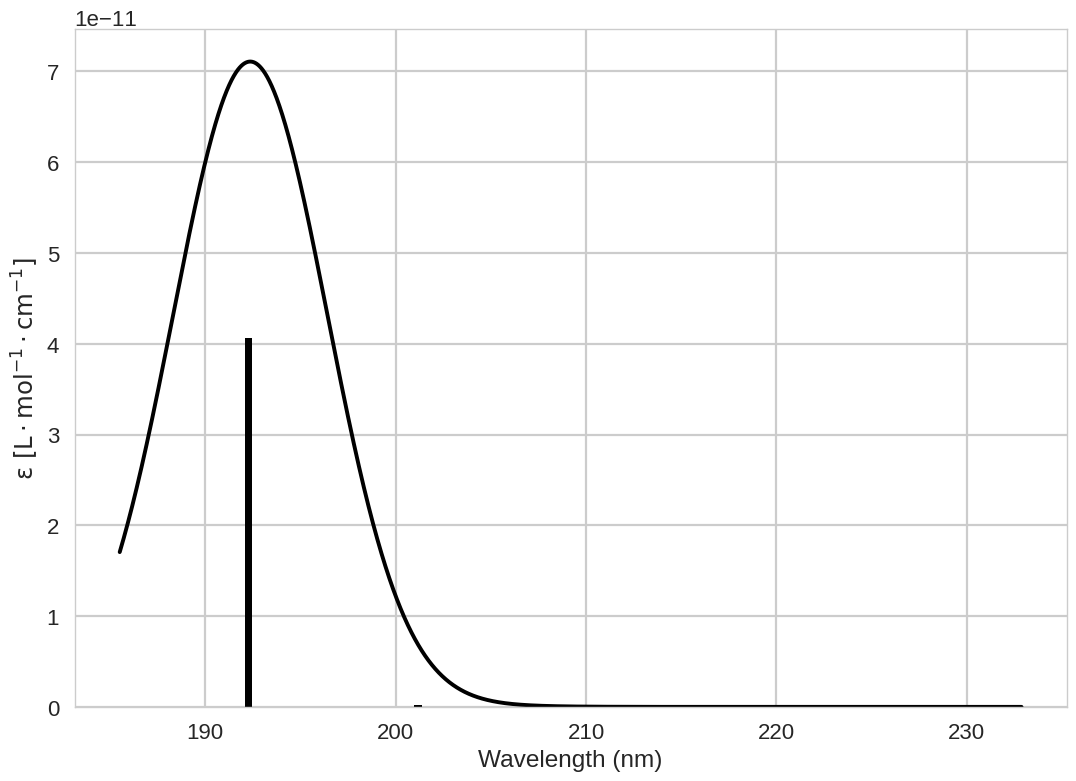

In [ ]:
fs = 20

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(opa_spectrum['convolution']['x'],
        opa_spectrum['convolution']['y'],
        color='black')
ax.bar(opa_spectrum['sticks']['poles'],
       opa_spectrum['sticks']['residues'],
       color='black',
       width=0.4)

ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel(r'$ \rm{\epsilon \ [L \cdot mol^{-1} \cdot cm^{-1}]} $')
fig.savefig('OPA.png', dpi=600, transparent=True)

##### 計算する励起状態の数を変えてOPAスペクトルを出力

In [ ]:
num_states = [4, 8, 12, 20]
responses = []
for num in num_states:
    response = tdscf_excitations(wfn_td, states=num)
    responses.append(response)

In [ ]:
spectrums = []
for response in responses:
    poles = [r['EXCITATION ENERGY'] for r in response]
    residues = [np.linalg.norm(r['ELECTRIC DIPOLE TRANSITION MOMENT (LEN)']) ** 2
                for r  in response]
    opa = spectrum(poles=poles,
                   residues=residues,
                   gamma=0.01,
                   out_units='nm')
    spectrums.append(opa)

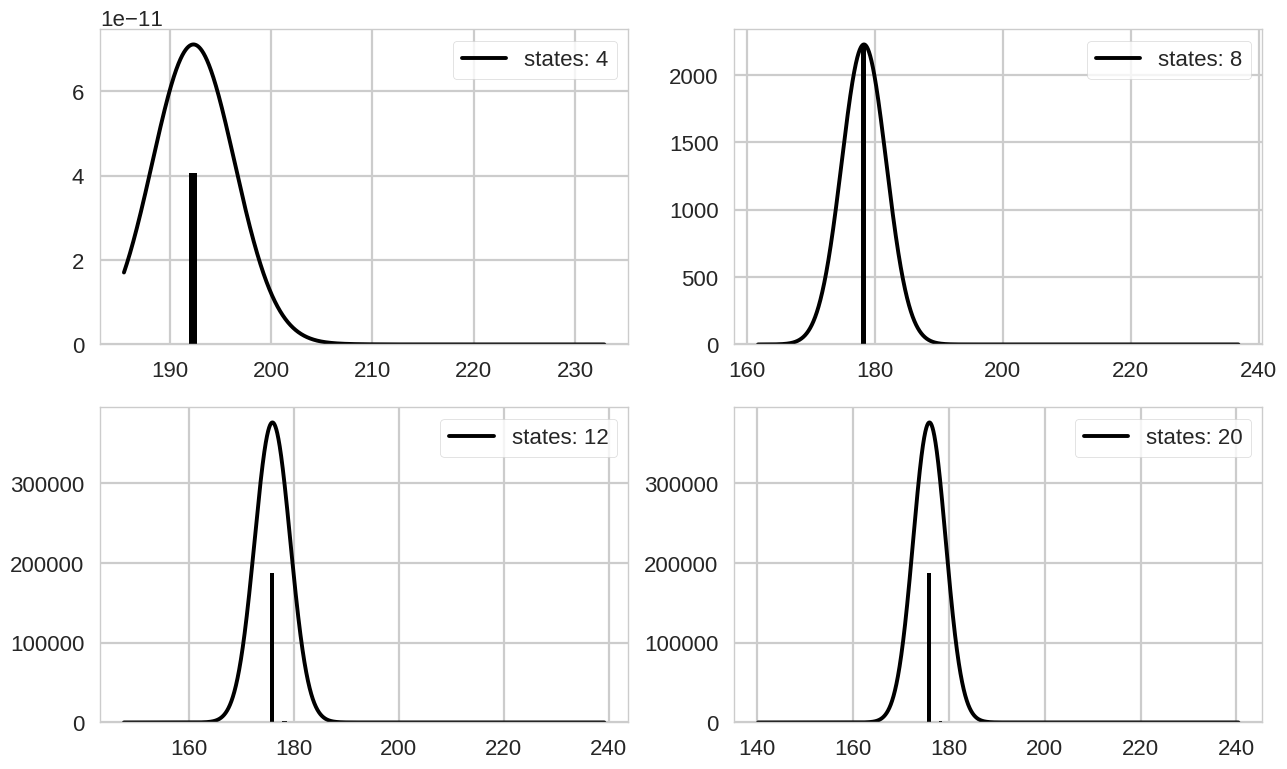

In [ ]:
fig = plt.figure(figsize=(15, 9))

for i, (state, spectrum) in enumerate(zip(num_states, spectrums), start=1):
    ax = fig.add_subplot(2, 2, i)
    ax.plot(spectrum['convolution']['x'],
            spectrum['convolution']['y'],
            color='black',
            label=f'states: {state}')
    ax.bar(spectrum['sticks']['poles'],
           spectrum['sticks']['residues'],
           color='black')
    ax.legend(frameon=True)

#### ECDスペクトル

In [ ]:
psi4.core.clean_options()

In [ ]:
def get_ECD_spectrum(excited_states: list) -> list[np.ndarray]:
    """
    ECDスペクトル描画用データを作成する
    Args:
        excited_state: TD計算で得られた励起状態のデータ

    Returns:
        np.ndarray: ECDスペクトル用のX軸
        np.ndarray: ECDスペクトル用のY軸
        np.ndarray: 吸収波長
        np.ndarray: 強度

    """
    from psi4.driver.p4util import spectrum

    poles = [excited_state['EXCITATION ENERGY']
             for excited_state in excited_states]
    residues = [excited_state['ROTATORY STRENGTH (LEN)']
                for excited_state in excited_states]
    ecd_spectrum = spectrum(poles=poles,
                            residues=residues,
                            kind='ECD',
                            gamma=0.01,
                            out_units='nm')

    x_broaden = ecd_spectrum['convolution']['x']
    y_broaden = ecd_spectrum['convolution']['y']
    x = ecd_spectrum['sticks']['poles']
    y = ecd_spectrum['sticks']['residues']

    return [x_broaden, y_broaden, x, y]

##### S体

In [ ]:
psi4.set_options({'SAVE_JK': True})
psi4.set_output_file('ECD_sample.log')

s_form = psi4.geometry('''
0 1
 C                 -0.45228216    0.14522821    0.00000000
 C                  0.94287784    0.14522821    0.00000000
 C                  1.64041584    1.35297921    0.00000000
 C                  0.94276184    2.56148821   -0.00119900
 C                 -0.45206316    2.56141021   -0.00167800
 C                 -1.14966416    1.35320421   -0.00068200
 H                 -1.00204116   -0.80708879    0.00045000
 H                  1.49238584   -0.80728479    0.00131500
 H                  1.49296184    3.51363121   -0.00125800
 H                 -1.00218516    3.51369121   -0.00263100
 H                 -2.24926816    1.35338721   -0.00086200
 C                  3.18041558    1.35309125    0.00088786
 H                  3.53672179    2.22050769    0.51618835
 C                  3.69458408    1.37096069   -1.45063253
 H                  4.76451996    1.35925545   -1.45018335
 H                  3.32868914    0.50953646   -1.96925494
 H                  3.34778992    2.25650596   -1.94098279
 O                  3.65678760    0.17734468    0.66088007
 H                  4.51713271    0.35378051    1.04853545
''')

In [ ]:
# 構造最適化と振動数計算
_, wfn_s = optfreq(s_form, 'cam-b3lyp/cc-pvdz')

Streaming output truncated to the last 5000 lines.
	  -0.000918  -0.000675  -0.002674   0.012942  -0.007040  -0.000332  -0.000277
	   0.000448   0.000279  -0.000781  -0.001023  -0.001095  -0.000922   0.000701
	  -0.004295   0.011320  -0.008661  -0.000092   0.000661  -0.000199  -0.000171
	   0.000207  -0.000117  -0.000018  -0.000882   0.000905   0.000037   0.000077
	   0.002110   0.001867   0.001795   0.001962  -0.000736  -0.000757  -0.000999
	  -0.001071
	  -0.001607   0.001656   0.000123  -0.000262   0.001165  -0.000433  -0.000382
	   0.001154   0.000080  -0.000533   0.000196  -0.000040  -0.001296  -0.002116
	   0.003731  -0.001379  -0.000913  -0.001730  -0.000161  -0.000234   0.000340
	   0.000168  -0.000269   0.000089  -0.000020   0.000807  -0.002344  -0.000109
	  -0.000310   0.000178  -0.003769   0.002603   0.015018   0.001562  -0.000525
	   0.000121   0.000131   0.000099  -0.000070   0.000403  -0.000017   0.000797
	  -0.000907   0.003432   0.002509   0.011993  -0.027514  -0.000273

Optimizer: Optimization complete!


INFO:psi4.driver.task_base:<<< JSON launch ... c1 425.4163072613705
INFO:psi4.driver.task_planner:PLANNING Atomic:  keywords={'SCF__D_CONVERGENCE': 1e-08, 'SCF__E_CONVERGENCE': 1e-08, 'SCF__INTS_TOLERANCE': 1e-12, 'PARENT_SYMMETRY': 'C1', 'SAVE_JK': 1, 'function_kwargs': {}}
INFO:psi4.driver.driver:Compute gradient(): method=cam-b3lyp, basis=cc-pvdz, molecule=C8H10O, nre=425.4163072613705
INFO:psi4.driver.driver:Return gradient(): -385.89876872006096
INFO:psi4.driver.driver:[[ 0.00005231 -0.00002837  0.00000458]
 [-0.00005699 -0.00002613  0.00000665]
 [-0.00002645  0.00004503 -0.00001200]
 [ 0.00005375 -0.00002294  0.00001508]
 [-0.00006169 -0.00002774  0.00000018]
 [-0.00000084  0.00006047 -0.00000571]
 [-0.00000899  0.00000532 -0.00000366]
 [ 0.00000903  0.00000413 -0.00000295]
 [-0.00000547 -0.00000149  0.00000007]
 [ 0.00000806  0.00000114  0.00000030]
 [ 0.00000264 -0.00000755  0.00000157]
 [ 0.00002620  0.00002171  0.00002564]
 [-0.00001073 -0.00002850 -0.00002033]
 [ 0.00001474 

 '392.5583' '422.6033' '479.0011' '539.9228' '614.0142']


In [ ]:
print(get_freqs(wfn_s))

[   45.5442605675606700   140.0104344788132948   224.8786463922528185
   266.3205335445760511   275.0614163648862132   316.4499895719325195
   392.5583360116911535   422.6032968990431300   479.0010990358379672
   539.9227514382322397   614.0142285059719143   636.4730691683710120
   727.5303827637026188   774.6847242561395888   791.6106661710284698
   880.1886996780216350   926.2308427381252613   952.1630865911365618
  1009.9627164567606314  1025.8353514873037966  1031.0544368945929818
  1035.5415637479361521  1065.6932760353881804  1101.7703833418668182
  1115.4291536987304880  1156.8261488628081679  1172.7880194091571866
  1192.7472164246289594  1217.4235004537251825  1253.0986548906823828
  1342.5764270985803250  1353.3593352099803724  1365.5526049510858684
  1397.3635142611578885  1422.4192590192972148  1466.6979434839274745
  1478.4460287380247792  1499.6650598915662158  1549.3292386725063352
  1676.2159684269736317  1699.4138772568614968  2992.2221431486323127
  3047.8975015043147

In [ ]:
print(s_form.save_string_xyz())

0 1
 C   -1.914289575502   -1.037107423411    0.213196492268
 C   -0.521699999772   -1.056355685034    0.249244881891
 C    0.202359901526    0.128438115351    0.122685252486
 C   -0.489832412012    1.332134761268   -0.029009775002
 C   -1.880108593504    1.352172076525   -0.066401447672
 C   -2.598238906307    0.164184305579    0.053162856263
 H   -2.469854527277   -1.971605494899    0.315094689663
 H    0.021037330108   -1.990658222885    0.384959468749
 H    0.066075938776    2.269765200657   -0.112999553360
 H   -2.406504575211    2.301395116940   -0.183709414640
 H   -3.689400811763    0.177289891554    0.027304286101
 C    1.716525534163    0.121666958899    0.124676601389
 H    2.058137009341    0.949865834465    0.776784164057
 C    2.282222915000    0.339204693753   -1.276611071255
 H    3.384780715352    0.355004030650   -1.252337443590
 H    1.957049353211   -0.474288941153   -1.942035466838
 H    1.942420249890    1.294831602949   -1.701746593496
 O    2.152479729898   -1.1

In [ ]:
show_3D(s_form)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

##### R体

In [ ]:
r_form = psi4.geometry('''
0 1
 C                 -0.45228216    0.14522821    0.00000000
 C                  0.94287784    0.14522821    0.00000000
 C                  1.64041584    1.35297921    0.00000000
 C                  0.94276184    2.56148821    0.00119900
 C                 -0.45206316    2.56141021    0.00167800
 C                 -1.14966416    1.35320421    0.00068200
 H                 -1.00204116   -0.80708879   -0.00045000
 H                  1.49238584   -0.80728479   -0.00131500
 H                  1.49296184    3.51363121    0.00125800
 H                 -1.00218516    3.51369121    0.00263100
 H                 -2.24926816    1.35338721    0.00086200
 C                  3.18041558    1.35309125   -0.00088786
 H                  3.53672179    2.22050769   -0.51618835
 C                  3.69458408    1.37096069    1.45063253
 H                  4.76451996    1.35925545    1.45018335
 H                  3.32868914    0.50953646    1.96925494
 H                  3.34778992    2.25650596    1.94098279
 O                  3.65678760    0.17734468   -0.66088007
 H                  4.51713271    0.35378051   -1.04853545
''')

In [ ]:
# 構造最適化・振動数計算
_, wfn_r = optfreq(r_form, 'cam-b3lyp/cc-pvdz')

Streaming output truncated to the last 5000 lines.
	   0.000056  -0.000407   0.000144  -0.000348   0.000358   0.001254  -0.000015
	  -0.000390   0.000103   0.000340   0.000127   0.000008   0.000195  -0.001568
	  -0.000193  -0.000376  -0.000524  -0.000990   0.000286   0.000313   0.000175
	  -0.000097  -0.000011   0.000227  -0.000251  -0.000646   0.000609  -0.000490
	   0.000304  -0.000011  -0.008394   0.008051   0.009225   0.000008  -0.000092
	  -0.000080  -0.000295   0.000109   0.000024   0.000173   0.000361   0.000651
	   0.000090   0.001154   0.013184   0.003314  -0.025059  -0.000334  -0.000488
	  -0.000340   0.000858  -0.000725   0.000089   0.000258  -0.000145   0.000037
	  -0.000918  -0.000675  -0.002674   0.012942  -0.007040  -0.000332  -0.000277
	   0.000448   0.000279  -0.000781  -0.001023  -0.001095  -0.000922   0.000701
	  -0.004295   0.011320  -0.008661  -0.000092   0.000661  -0.000199  -0.000171
	   0.000207  -0.000117  -0.000018  -0.000882   0.000905   0.000037   0.000077
	

Optimizer: Optimization complete!


INFO:psi4.driver.task_base:<<< JSON launch ... c1 425.4163108929114
INFO:psi4.driver.task_planner:PLANNING Atomic:  keywords={'SCF__D_CONVERGENCE': 1e-08, 'SCF__E_CONVERGENCE': 1e-08, 'SCF__INTS_TOLERANCE': 1e-12, 'PARENT_SYMMETRY': 'C1', 'SAVE_JK': 1, 'function_kwargs': {}}
INFO:psi4.driver.driver:Compute gradient(): method=cam-b3lyp, basis=cc-pvdz, molecule=C8H10O, nre=425.4163108929114
INFO:psi4.driver.driver:Return gradient(): -385.89876871980255
INFO:psi4.driver.driver:[[ 0.00005232 -0.00002835 -0.00000458]
 [-0.00005698 -0.00002612 -0.00000665]
 [-0.00002646  0.00004503  0.00001199]
 [ 0.00005374 -0.00002295 -0.00001509]
 [-0.00006167 -0.00002774 -0.00000018]
 [-0.00000083  0.00006049  0.00000571]
 [-0.00000899  0.00000531  0.00000366]
 [ 0.00000903  0.00000414  0.00000295]
 [-0.00000548 -0.00000151 -0.00000008]
 [ 0.00000807  0.00000112 -0.00000031]
 [ 0.00000266 -0.00000755 -0.00000157]
 [ 0.00002618  0.00002172 -0.00002565]
 [-0.00001074 -0.00002851  0.00002034]
 [ 0.00001474 

 '392.5565' '422.6025' '478.9983' '539.9237' '614.0209']


In [ ]:
print(get_freqs(wfn_r))

[   45.5433502648577715   140.0087567740947350   224.8771629086543840
   266.3208500958078844   275.0624109318396222   316.4487719216951973
   392.5564921379472594   422.6024735112042094   478.9983272919570254
   539.9236975096096103   614.0208579726339622   636.4753033974704977
   727.5304743017578630   774.6953253612165327   791.6129600399394803
   880.1887167102404419   926.2231384818601327   952.1634013511325065
  1009.9630332179153811  1025.8306017037559741  1031.0545702959288974
  1035.5396864167464628  1065.6922164479681214  1101.7737588057609628
  1115.4304784335429304  1156.8217442037591809  1172.7863690612562095
  1192.7496844248885282  1217.4278378059977967  1253.0964526980412757
  1342.5751201800403578  1353.3581300666096467  1365.5530921860279250
  1397.3638108843661030  1422.4186092156678569  1466.6975010809710511
  1478.4450325553341372  1499.6709456395105917  1549.3333601970391555
  1676.2162660629526272  1699.4131234684541596  2992.2176592700488982
  3047.9002517740987

In [ ]:
print(r_form.save_string_xyz())

0 1
 C   -1.914289585251   -1.037107391218   -0.213196546906
 C   -0.521700018785   -1.056355693875   -0.249244911496
 C    0.202359888427    0.128438083027   -0.122685240183
 C   -0.489832395148    1.332134726550    0.029009824476
 C   -1.880108557439    1.352172067292    0.066401477736
 C   -2.598238878040    0.164184333123   -0.053162883783
 H   -2.469854548562   -1.971605437309   -0.315094791069
 H    0.021037289683   -1.990658226449   -0.384959523736
 H    0.066075962643    2.269765139337    0.112999639756
 H   -2.406504510161    2.301395094545    0.183709465872
 H   -3.689400759216    0.177289941301   -0.027304336925
 C    1.716525504983    0.121666937875   -0.124676608710
 H    2.058136944487    0.949865779696   -0.776784225432
 C    2.282222911263    0.339204770101    1.276611035974
 H    3.384780707569    0.355004150113    1.252337378178
 H    1.957049400094   -0.474288839265    1.942035479738
 H    1.942420223851    1.294831686608    1.701746515097
 O    2.152479723607   -1.1

In [ ]:
show_3D(r_form)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [ ]:
# TD-DFT計算
_, wfn_tds = psi4.energy('cam-b3lyp/aug-cc-pvdz',
                         molecule=s_form,
                         return_wfn=True)
excited_states_S = tdscf_excitations(wfn_tds, states=6)

INFO:psi4.driver.task_planner:PLANNING Atomic:  keywords={'SCF__INTS_TOLERANCE': 1e-12, 'SAVE_JK': 1, 'function_kwargs': {}}
INFO:psi4.driver.driver:Compute energy(): method=cam-b3lyp, basis=aug-cc-pvdz, molecule=default, nre=425.416304814413
INFO:psi4.driver.driver:Return energy(): -385.9278577129447


In [ ]:
_, wfn_tdr = psi4.energy('cam-b3lyp/aug-cc-pvdz',
                         molecule=r_form,
                         return_wfn=True)
excited_states_R = tdscf_excitations(wfn_tdr, states=6)

INFO:psi4.driver.task_planner:PLANNING Atomic:  keywords={'SCF__INTS_TOLERANCE': 1e-12, 'SAVE_JK': 1, 'function_kwargs': {}}
INFO:psi4.driver.driver:Compute energy(): method=cam-b3lyp, basis=aug-cc-pvdz, molecule=default, nre=425.4163108929114
INFO:psi4.driver.driver:Return energy(): -385.92785933407123


In [ ]:
# ECDスペクトル
x_broaden_S, y_broaden_S, x_S, y_S = get_ECD_spectrum(excited_states_S)

In [ ]:
x_broaden_R, y_broaden_R, x_R, y_R = get_ECD_spectrum(excited_states_R)

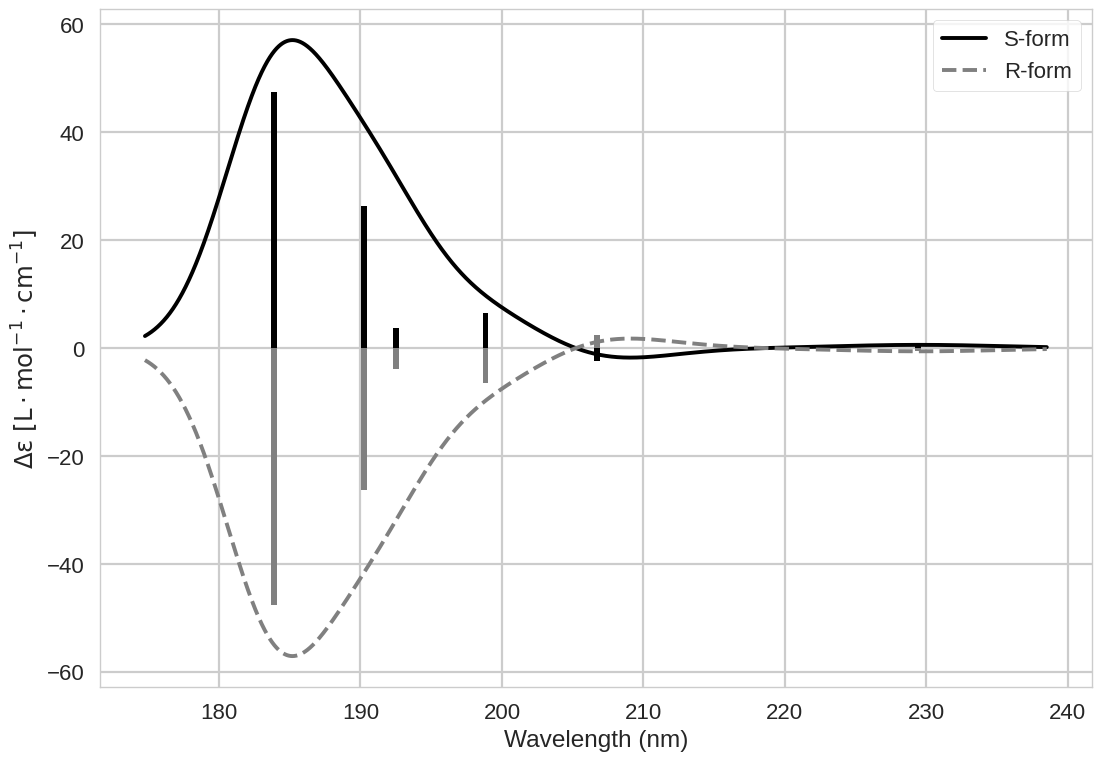

In [ ]:
# 描画
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x_broaden_S, y_broaden_S, color='black', label='S-form')
ax.bar(x_S, y_S, color='black', width=0.4)
ax.plot(x_broaden_R, y_broaden_R, '--', color='gray', label='R-form')
ax.bar(x_R, y_R, color='gray', width=0.4)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel(r'$ \rm{\Delta \epsilon} \  [L \cdot mol^{-1} \cdot cm^{-1}]$')
ax.legend(frameon=True)
fig.savefig('ECD_RS.png', dpi=600, transparent=True)

#### 計算する励起状態の数を変化させてECDスペクトル

In [ ]:
psi4.set_output_file('ECD_comparison.log')

PosixPath('ECD_comparison.log')

INFO:psi4.driver.task_planner:PLANNING Atomic:  keywords={'SCF__INTS_TOLERANCE': 1e-12, 'SAVE_JK': 1, 'function_kwargs': {}}
INFO:psi4.driver.driver:Compute energy(): method=cam-b3lyp, basis=aug-cc-pvdz, molecule=default, nre=425.4163072613705
INFO:psi4.driver.driver:Return energy(): -385.9278612210216
INFO:psi4.driver.task_planner:PLANNING Atomic:  keywords={'SCF__INTS_TOLERANCE': 1e-12, 'SAVE_JK': 1, 'function_kwargs': {}}
INFO:psi4.driver.driver:Compute energy(): method=cam-b3lyp, basis=aug-cc-pvdz, molecule=default, nre=425.4163072613705
INFO:psi4.driver.driver:Return energy(): -385.9278612210209
INFO:psi4.driver.task_planner:PLANNING Atomic:  keywords={'SCF__INTS_TOLERANCE': 1e-12, 'SAVE_JK': 1, 'function_kwargs': {}}
INFO:psi4.driver.driver:Compute energy(): method=cam-b3lyp, basis=aug-cc-pvdz, molecule=default, nre=425.4163072613705
INFO:psi4.driver.driver:Return energy(): -385.92786122102154
INFO:psi4.driver.task_planner:PLANNING Atomic:  keywords={'SCF__INTS_TOLERANCE': 1e-12,

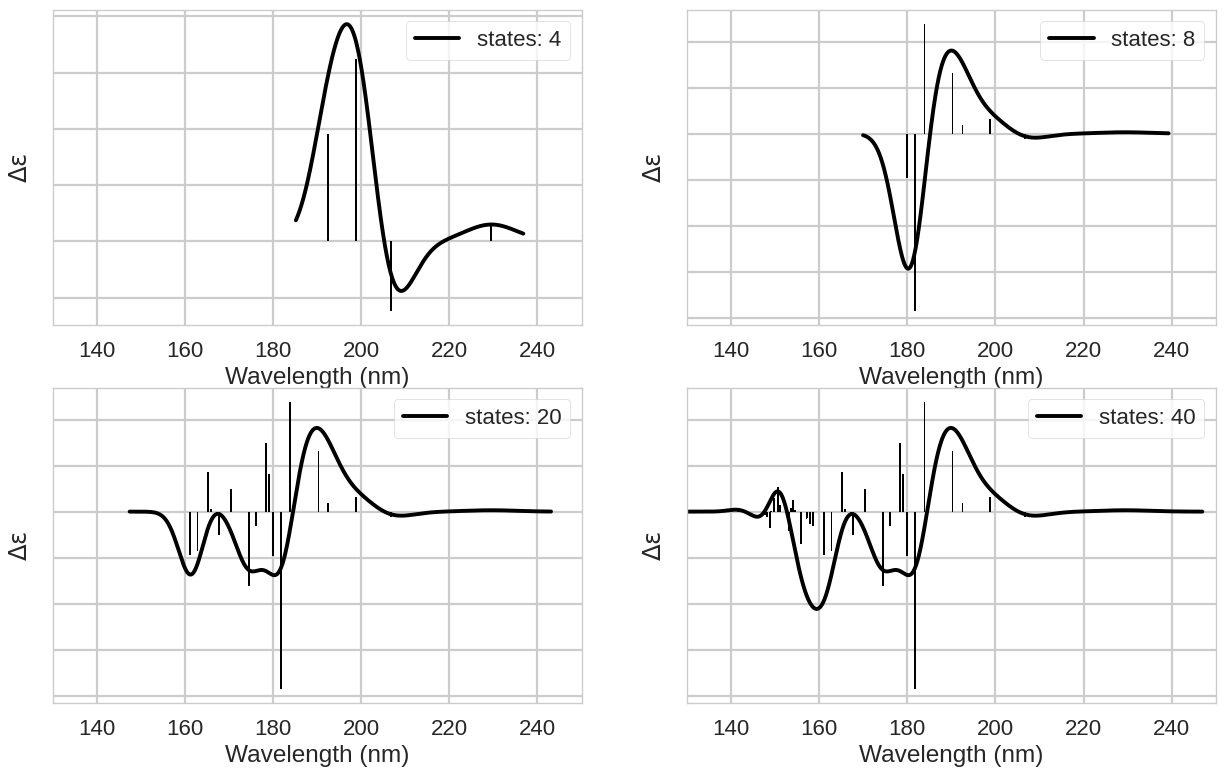

In [ ]:
num_states = [4, 8, 20, 40]
states = []

fig = plt.figure(figsize=(15,9))
for i, num in enumerate(num_states, 1):
    _, wfn_td = psi4.energy('cam-b3lyp/aug-cc-pvdz',
                            molecule=s_form,
                            return_wfn=True)
    excited_states = tdscf_excitations(wfn_td, states=num)
    states.append(excited_states)
    x_broaden, y_broaden, x, y  = get_ECD_spectrum(excited_states)
    ax = fig.add_subplot(2, 2, i)
    ax.plot(x_broaden, y_broaden, color='black', label=f'states: {num}')
    ax.bar(x, y, color='black', width=0.4)
    ax.set_xlabel('Wavelength (nm)')
    ax.set_xlim(130, 250)
    ax.set_xticks([140, 160, 180, 200, 220, 240])
    ax.set_xticklabels([140, 160, 180, 200, 220, 240])
    ax.set_yticklabels([])
    ax.set_ylabel(r'$ \rm{\Delta \epsilon} $')
    ax.legend(frameon=True)
fig.savefig('ECD_comparison.png', dpi=600, transparent=True)